In [21]:
import numpy as np
import pandas as pd
import time
import math

from pyspark import SparkContext
from pyspark import Row
from pyspark.sql import SQLContext
from pyspark.ml.feature import Word2Vec
from pyspark.ml.clustering import KMeans
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# ACTION REQUIRED to get your credentials:
1. Click on the empty cell below 
2. Then look for the data icon on the top right (drawing with zeros and ones) and click on it
3. You should see the tweets.gz file, then click on "insert to code"

 > **You should see a python dictionary inserted in the cell above with your credentials**

4. Replace the dictionary name to credentials_1 (if it is not already)
4. Run the below cell 

# Run the next cell to set up a connection to your object storage

In [5]:
#hidden_cell
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# This function includes credentials to your Object Storage.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config(name, creds):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage V3 using Spark"""
    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', creds['project_id']) 
    hconf.set(prefix + '.username', creds['user_id'])  
    hconf.set(prefix + '.password', creds['password'])  
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', True)

name = 'keystone'
set_hadoop_config(name, credentials_1)

# Read the tweets as a Spark dataframe and count

In [6]:
t0 = time.time()
datapath = 'swift://'+credentials_1['container']+'.keystone/tweets.gz'
tweets = sqlContext.read.json(datapath)
tweets.registerTempTable("tweets")
twr = tweets.count()
print "Number of tweets read: ", twr 
print "Elapsed time (seconds): ", time.time() - t0

Number of tweets read:  239082
Elapsed time (seconds):  169.954779148


# The keywords: christmas, santa, turkey, ...

In [7]:
filter = ['santa','claus','merry','christmas','eve',
          'congrat','holiday','jingle','bell','silent',
          'night','faith','hope','family','new',
          'year','spirit','turkey','ham','food']
pd.DataFrame(filter,columns=['word']).head(5)

,word
0,santa
1,claus
2,merry
3,christmas
4,eve


# Use Spark SQL to Filter Relevant Tweets:

Relevant tweets: 
+ In english and
+ Contain at least one of the keywords

In [8]:
# Construct SQL Command
t0 = time.time()
sqlString = "("
for substr in filter: 
    sqlString = sqlString+"text LIKE '%"+substr+"%' OR "
    sqlString = sqlString+"text LIKE '%"+substr.upper()+"%' OR "
sqlString=sqlString[:-4]+")"
sqlFilterCommand = "SELECT lang, text FROM tweets WHERE (lang = 'en') AND "+sqlString

# Query tweets in english that contain at least one of the keywords
tweetsDF = sqlContext.sql(sqlFilterCommand).cache()
twf = tweetsDF.count()
print "Number of tweets after filtering: ", twf 
# last line add ~9 seconds (from ~0.72 seconds to ~9.42 seconds)
print "Elapsed time (seconds): ", time.time() - t0

print "Percetage of Tweets Used: ", float(twf)/twr

Number of tweets after filtering:  15142
Elapsed time (seconds):  107.629510164
Percetage of Tweets Used:  0.0633339189065


# Parse Tweets and Remove Stop Words 

In [9]:
tweetsRDD = tweetsDF.select('text').rdd

def parseAndRemoveStopWords(text):
    t = text[0].replace(";"," ").replace(":"," ").replace('"',' ').replace('-',' ').replace("?"," ")
    t = t.replace(',',' ').replace('.',' ').replace('!','').replace("'"," ").replace("/"," ").replace("\\"," ")
    t = t.lower().split(" ")
    return t

tw = tweetsRDD.map(parseAndRemoveStopWords)

# Train Word2Vec Model

+ Word2vec returns a dataframe with words and vectors
+ Sometimes you need to run this block twice (strange reason that need to de-bug)

In [11]:
# map to df
twDF = tw.map(lambda p: Row(text=p)).toDF()

# default minCount = 5 (we may need to try something larger: 20-100 to reduce cost)
# default vectorSize = 100 (we may want to keep default)
t0 = time.time()
word2Vec = Word2Vec(vectorSize=100, minCount=10, inputCol="text", outputCol="result")
modelW2V = word2Vec.fit(twDF)
wordVectorsDF = modelW2V.getVectors()
print "Elapsed time (seconds) to train Word2Vec: ", time.time() - t0

Elapsed time (seconds) to train Word2Vec:  15.4517819881


In [12]:
vocabSize = wordVectorsDF.count()
print "Vocabulary Size: ", vocabSize

Vocabulary Size:  1830


# Find top N closest words 

In [13]:
word = 'christmas'
topN = 5
###
synonymsDF = modelW2V.findSynonyms(word, topN).toPandas()

In [14]:
synonymsDF[['word']].head(topN)

,word
0,eve
1,🎄
2,🎅
3,wish
4,xmas


# As Expected, Unrelated terms are Not Accurate

In [15]:
word = 'dog'
topN = 5
###
synonymsDF = modelW2V.findSynonyms(word, topN).toPandas()

In [16]:
synonymsDF[['word']].head(topN)

,word
0,continue
1,#openfollow
2,sea
3,took
4,sing


# PCA on Top of Word2Vec using DF (spark.ml)

In [17]:
dfW2V = wordVectorsDF.select('vector').withColumnRenamed('vector','features')

numComponents = 3
pca = PCA(k = numComponents, inputCol = 'features', outputCol = 'pcaFeatures')
model = pca.fit(dfW2V)
dfComp = model.transform(dfW2V).select("pcaFeatures")

# 3D Visualization

In [18]:
def topNwordsToPlot(dfComp,wordVectorsDF,word,nwords):

    compX = np.asarray(dfComp.map(lambda vec: vec[0][0]).collect())
    compY = np.asarray(dfComp.map(lambda vec: vec[0][1]).collect())
    compZ = np.asarray(dfComp.map(lambda vec: vec[0][2]).collect())

    words = np.asarray(wordVectorsDF.select('word').toPandas().values.tolist())
    Feat = np.asarray(wordVectorsDF.select('vector').rdd.map(lambda v: np.asarray(v[0])).collect())

    Nw = words.shape[0]                # total number of words
    ind_star = np.where(word == words) # find index associated to 'word' 
    wstar = Feat[ind_star,:][0][0]     # vector associated to 'word'
    nwstar = math.sqrt(np.dot(wstar,wstar)) # norm of vector assoicated with 'word'

    dist = np.zeros(Nw) # initialize vector of distances
    i = 0
    for w in Feat: # loop to compute cosine distances between 'word' and the rest of the words 
        den = math.sqrt(np.dot(w,w))*nwstar  # denominator of cosine distance
        dist[i] = abs( np.dot(wstar,w) )/den   # cosine distance to each word
        i = i + 1

    indexes = np.argpartition(dist,-(nwords+1))[-(nwords+1):]
    di = []
    for j in range(nwords+1):
        di.append(( words[indexes[j]], dist[indexes[j]], compX[indexes[j]], compY[indexes[j]], compZ[indexes[j]] ) )

    result=[]
    for elem in sorted(di,key=lambda x: x[1],reverse=True):
        result.append((elem[0][0], elem[2], elem[3], elem[4]))
    
    return pd.DataFrame(result,columns=['word','X','Y','Z'])

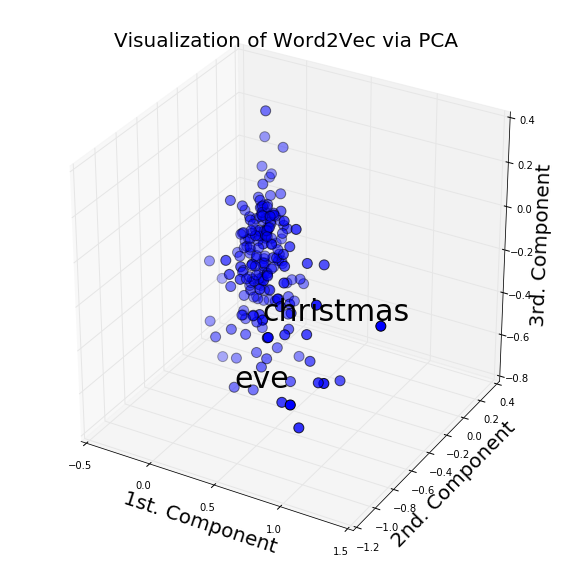

In [19]:
word = 'christmas'
nwords = 200

#############

r = topNwordsToPlot(dfComp,wordVectorsDF,word,nwords)

############
fs=20 #fontsize
w = r['word']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

height = 10
width = 10
fig.set_size_inches(width, height)

ax.scatter(r['X'], r['Y'], r['Z'], color='red', s=100, marker='o', edgecolors='black')
for i, txt in enumerate(w):
    if(i<2):
        ax.text(r['X'].ix[i],r['Y'].ix[i],r['Z'].ix[i], '%s' % (txt), size=30, zorder=1, color='k')
        
ax.set_xlabel('1st. Component', fontsize=fs)
ax.set_ylabel('2nd. Component', fontsize=fs)
ax.set_zlabel('3rd. Component', fontsize=fs)
ax.set_title('Visualization of Word2Vec via PCA', fontsize=fs)
ax.grid(True)
plt.show()

# K-means on top of Word2Vec using DF (spark.ml)

In [20]:
t0 = time.time()

K = int(math.floor(math.sqrt(float(vocabSize)/2)))
         # K ~ sqrt(n/2) this is a rule of thumb for choosing K,
         # where n is the number of words in the model
         # feel free to choose K with a fancier algorithm
         
dfW2V = wordVectorsDF.select('vector').withColumnRenamed('vector','features')
kmeans = KMeans(k=K, seed=1)
modelK = kmeans.fit(dfW2V)
labelsDF = modelK.transform(dfW2V).select('prediction').withColumnRenamed('prediction','labels')

print "Number of Clusters (K) Used: ", K
print "Elapsed time (seconds) :", time.time() - t0

Number of Clusters (K) Used:  30
Elapsed time (seconds) : 3.62755489349
